# diffusion model based image generation and maintenance

# papers and references
- https://paperswithcode.com/task/text-to-image-generation
- https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946/

# attempt

flower image dataset
- https://www.kaggle.com/datasets/aksha05/flower-image-dataset

In [1]:
# import kagglehub
# path = kagglehub.dataset_download("aksha05/flower-image-dataset")
# print("Path to dataset files:", path)

2025-05-06 15:28:42.097660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746545322.341329      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746545322.410856      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Epochs:   0%|          | 0/450 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

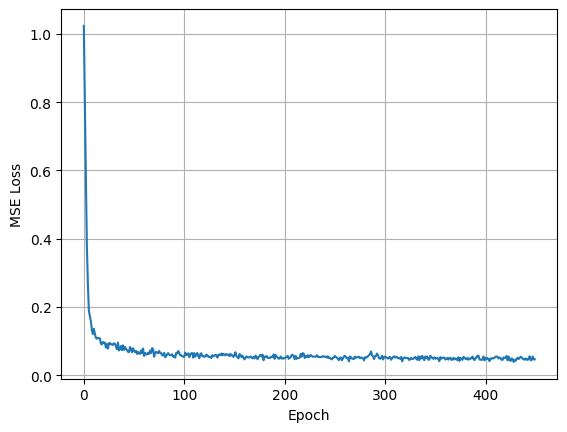

In [2]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import imageio
import numpy as np
from matplotlib import animation
from IPython.display import HTML

# CLIP for text conditioning
from transformers import CLIPTokenizer, CLIPTextModel

# ----- 0. Custom flat-folder Flower dataset -----
class FlowerDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        # class names are the prefix before the first underscore
        self.classes = sorted(set(f.split('_')[0] for f in self.image_files))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        path = os.path.join(self.image_dir, fname)
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_name = fname.split('_')[0]
        label = self.class_to_idx[label_name]
        return img, label

# ----- 1. Configuration -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
epochs = 450 # 50
lr = 2e-4
image_size = 56
channels = 3           # RGB
T = 1000
time_emb_dim = 128
text_emb_dim = 512
cond_drop_prob = 0.1

# ----- 2. Beta schedule -----
beta_start, beta_end = 1e-4, 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1. - betas
alpha_cumprod = torch.cumprod(alphas, dim=0)
alpha_cumprod_prev = F.pad(alpha_cumprod[:-1], (1,0), value=1.0)

def extract(a, t, x_shape):
    out = a.gather(-1, t)
    return out.view(-1, *([1] * (len(x_shape) - 1)))

# ----- 3. Positional / time embedding -----
class LearnablePosEmb(nn.Module):
    def __init__(self, dim, max_time=T):
        super().__init__()
        self.emb = nn.Embedding(max_time, dim)
    def forward(self, t):
        return self.emb(t)

# ----- 4. Residual block -----
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_dim, out_ch)
        self.block = nn.Sequential(
            nn.GroupNorm(1, in_ch),
            nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(1, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x, t_emb):
        h = self.block(x)
        te = self.time_mlp(t_emb)[:, :, None, None]
        h = h + te
        return h + self.res_conv(x)

# ----- 5. U-Net with text conditioning -----
class SimpleUNet(nn.Module):
    def __init__(self, img_ch=1, base_ch=64, time_dim=128, text_dim=512):
        super().__init__()
        self.time_mlp = nn.Sequential(
            LearnablePosEmb(time_dim),
            nn.Linear(time_dim, time_dim*4),
            nn.SiLU(),
            nn.Linear(time_dim*4, time_dim),
        )
        self.text_proj = nn.Linear(text_dim, time_dim)
        self.down1 = ResidualBlock(img_ch, base_ch, time_dim)
        self.down2 = ResidualBlock(base_ch, base_ch*2, time_dim)
        self.bot   = ResidualBlock(base_ch*2, base_ch*2, time_dim)
        self.up1   = ResidualBlock(base_ch*4, base_ch, time_dim)
        self.up2   = ResidualBlock(base_ch*2, base_ch, time_dim)
        self.out   = nn.Sequential(
            nn.GroupNorm(1, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, img_ch, 1)
        )
        self.pool = nn.MaxPool2d(2)
        self.up   = nn.Upsample(scale_factor=2, mode='nearest')
    def forward(self, x, t, text_emb=None):
        t_emb = self.time_mlp(t)
        if text_emb is not None:
            t_emb = t_emb + self.text_proj(text_emb)
        d1 = self.down1(x, t_emb)
        d2 = self.down2(self.pool(d1), t_emb)
        b  = self.bot(self.pool(d2), t_emb)
        u1 = self.up1(torch.cat([self.up(b), d2], dim=1), t_emb)
        u2 = self.up2(torch.cat([self.up(u1), d1], dim=1), t_emb)
        return self.out(u2)

# ----- 6. Data -----
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # <-- fixed to force 28×28
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*2 - 1)
])
dataset_path = '/kaggle/input/flower-image-dataset/flowers'
train_ds = FlowerDataset(dataset_path, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
# print(train_ds.classes)

# ----- 7. CLIP text encoder -----
tokenizer    = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
for p in text_encoder.parameters(): p.requires_grad = False
text_encoder.eval()
with torch.no_grad():
    lbls = train_ds.classes
    txt = tokenizer(lbls, padding=True, return_tensors="pt").to(device)
    label_embs = text_encoder(**txt).last_hidden_state[:,0,:]  # [num_classes,512]

# ----- 8. Model & optimizer -----
model = SimpleUNet(channels, 64, time_emb_dim, text_emb_dim).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=lr)

# ----- 9. Training -----
loss_hist = []
for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    tot = 0
    for x, labels in train_loader:
        x = x.to(device)
        b = x.size(0)
        t = torch.randint(0, T, (b,), device=device)
        noise = torch.randn_like(x)
        a_bar = extract(alpha_cumprod, t, x.shape)
        xt = torch.sqrt(a_bar)*x + torch.sqrt(1-a_bar)*noise
        txt_emb = label_embs[labels].to(device)
        if torch.rand(1).item() < cond_drop_prob:
            txt_in = None
        else:
            txt_in = txt_emb
        pred = model(xt, t, txt_in)
        loss = F.mse_loss(pred, noise)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*b
    loss_hist.append(tot/len(train_loader.dataset))

# Plot training loss
plt.plot(loss_hist); plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.grid(True); plt.show()

# ----- 10. Sampling w/ intermediates -----
@torch.no_grad()
def p_sample(x_t, t, cond_emb, uncond_emb, scale):
    b = x_t.size(0)
    t_b = torch.full((b,), t, device=device, dtype=torch.long)
    if uncond_emb is not None:
        e0 = model(x_t, t_b, uncond_emb)
        e1 = model(x_t, t_b, cond_emb)
        e = e0 + scale*(e1-e0)
    else:
        e = model(x_t, t_b, cond_emb)
    a_t   = extract(alphas,         t_b, x_t.shape)
    a_bar = extract(alpha_cumprod,  t_b, x_t.shape)
    a_tmp = extract(alpha_cumprod_prev, t_b, x_t.shape)
    b_t   = extract(betas,          t_b, x_t.shape)
    x0    = (x_t - torch.sqrt(1-a_bar)*e)/torch.sqrt(a_bar)
    coef1 = b_t*torch.sqrt(a_tmp)/(1-a_bar)
    coef2 = torch.sqrt(a_t)*(1-a_tmp)/(1-a_bar)
    mu    = coef1*x0 + coef2*x_t
    var   = b_t*(1-a_tmp)/(1-a_bar)
    return mu + torch.sqrt(var)*torch.randn_like(x_t) if t>0 else mu

@torch.no_grad()
def sample_with_intermediates(prompt, scale=3.0):
    txt = tokenizer([prompt], padding=True, return_tensors="pt")
    txt = {k:v.to(device) for k,v in txt.items()}
    c_emb = text_encoder(**txt).last_hidden_state[:,0,:]
    if scale!=1.0:
        empty = tokenizer([""], padding=True, return_tensors="pt")
        empty = {k:v.to(device) for k,v in empty.items()}
        u_emb = text_encoder(**empty).last_hidden_state[:,0,:]
    else:
        u_emb = None

    x = torch.randn((1,channels,image_size,image_size), device=device)
    intermediates = []
    for t in reversed(range(T)):
        x = p_sample(x, t, c_emb, u_emb, scale)
        frame = ((x+1)/2).cpu().squeeze().clamp(0,1).numpy()
        intermediates.append(frame)
    return x.clamp(-1,1), np.stack(intermediates, axis=0)


In [ ]:
# ----- 11. Generate & animate for one prompt -----
prompt = "Orchids"  # your prompt
final_img, inter = sample_with_intermediates(prompt, scale=10.0)

# Show final image (RGB)
to_img = lambda x: ((x+1)/2).cpu().squeeze().clamp(0,1).permute(1,2,0)  # <-- permute channels last
plt.figure(figsize=(3,3))
plt.imshow(to_img(final_img))  
plt.title(prompt); plt.axis('off')
plt.show()

# Inline JS animation (RGB)
frames = inter.transpose(0,2,3,1)  # <-- reshape from (T,3,<image size>,<image size>) to (T,<image size>,<image size>,3)
fig = plt.figure(figsize=(3,3))
im = plt.imshow(frames[0], animated=True) 
plt.axis('off')

def update(i):
    im.set_array(frames[i])
    return [im]

T = len(frames)

animated = animation.FuncAnimation(fig, update, frames=T, interval=20)
HTML(animated.to_jshtml())


## diffusion model saving 

In [4]:
torch.save(model, "text_to_image_flower_model.pth")

## diffusion model loading

In [5]:
# Loading model directly 
saved_model = torch.load("text_to_image_flower_model.pth", weights_only=False)
saved_model.to(device)
saved_model.eval()

SimpleUNet(
  (time_mlp): Sequential(
    (0): LearnablePosEmb(
      (emb): Embedding(1000, 128)
    )
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): SiLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
  )
  (text_proj): Linear(in_features=512, out_features=128, bias=True)
  (down1): ResidualBlock(
    (time_mlp): Linear(in_features=128, out_features=64, bias=True)
    (block): Sequential(
      (0): GroupNorm(1, 3, eps=1e-05, affine=True)
      (1): SiLU()
      (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GroupNorm(1, 64, eps=1e-05, affine=True)
      (4): SiLU()
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (res_conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (down2): ResidualBlock(
    (time_mlp): Linear(in_features=128, out_features=128, bias=True)
    (block): Sequential(
      (0): GroupNorm(1, 64, eps=1e-05, affine=True)
      (1): SiLU()
      (2

['bougainvillea', 'daisies', 'garden', 'gardenias', 'hibiscus', 'hydrangeas', 'lilies', 'orchids', 'peonies', 'tulip']


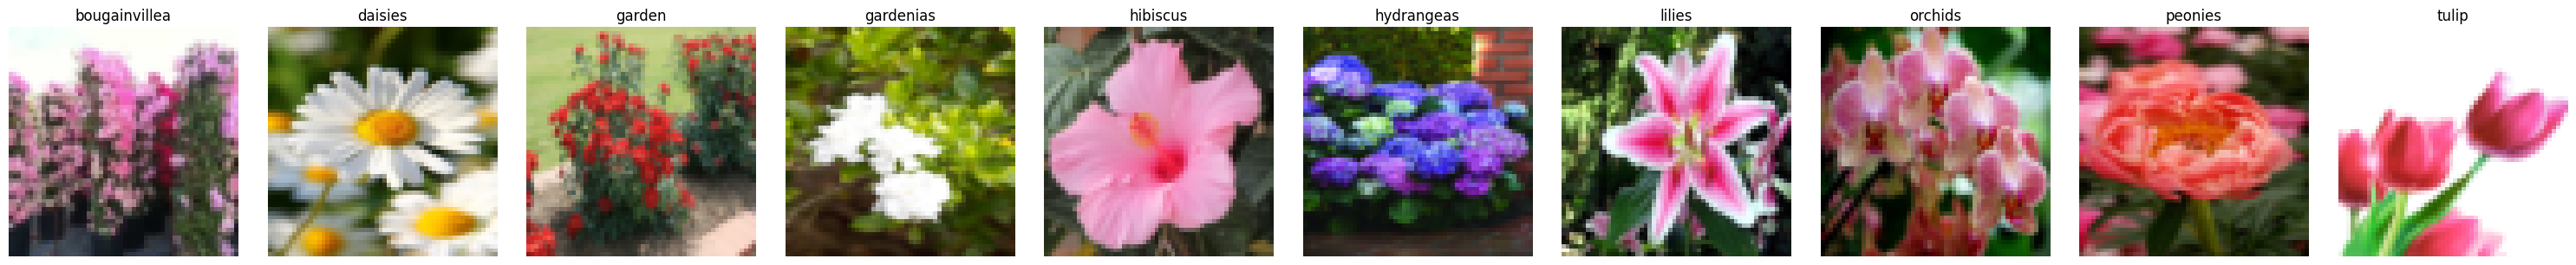

In [6]:
import random
import matplotlib.pyplot as plt

# Print class names
print(train_ds.classes)

# Map from class index to image paths
samples_per_class = {cls: None for cls in train_ds.classes}

# Randomly find one image per class
for img, label in train_ds:
    cls = train_ds.classes[label]
    if samples_per_class[cls] is None:
        samples_per_class[cls] = img
    if all(v is not None for v in samples_per_class.values()):
        break

# Plotting
fig, axs = plt.subplots(1, len(samples_per_class), figsize=(3*len(samples_per_class), 3))
if len(samples_per_class) == 1:
    axs = [axs]  # make iterable if only one class
for ax, (cls, img) in zip(axs, samples_per_class.items()):
    ax.imshow((img.permute(1, 2, 0) + 1) / 2)  # de-normalize if you used x*2-1
    ax.set_title(cls)
    ax.axis('off')

plt.tight_layout()
plt.show()
